In [1]:
#Set number of threads to use
import os
nthreads = 4
os.environ["MKL_NUM_THREADS"] = str(nthreads)
os.environ["NUMEXPR_NUM_THREADS"] = str(nthreads)
os.environ["OMP_NUM_THREADS"] = str(nthreads)

In [2]:
import sys

In [3]:
sys.path.insert(1,'../CoreFunctions/')

In [4]:
from MerfishSimulator import *
from MerfishSimulator import merfish_data_generator as mdg

# Load Reference
Load in the hippocampus cells (29224) from the Allen Mouse Brain Atlas. We subset this matrix to the marker genes (83) we had for our MERFISH dataset, but this can be performed with any number of genes. We also shrank the values for simulation purposes by taking the square root of the counts and rounding the values.

In [5]:
sc_ref = pd.read_csv('../data/sc_ref.csv.gz',
                    index_col=0)

In [6]:
sc_ref.shape

(29224, 83)

# Read in Celltypes

In [7]:
celltypes = pd.read_csv('../data/celltypes.txt.gz',
                       header = None).to_numpy().ravel()

In [8]:
celltypes

array(['Pvalb_8', 'Vip_9', 'Lamp5_5', ..., 'Vip_10', 'Sst_27',
       'Lamp5 Lhx6_1'], dtype=object)

# Set Parameters: (assume all distance values are in microns)
low_cell: smallest radius of a cell  
  
high_cell: largest radius of a cell  
  
dst_btw_cell: How much to increase/decrease the distance between cells. Negative numbers increases cell density. Positive numbers decreases cell density.  
  
unif_const: Changes the cell type distribution from that of the single cell data to uniform. Smaller numbers close to 0 give the true distribution. Larger numbers > 10 are uniform.
  
grid_size: size of the x,y,z map to simulate cells in.
  
noise_in_dist: adds uneveness to the radius of a cell. Creates rough edges.
  
pixels_per_micron: Resolution of the sample. Larger numbers increases resolution, smaller decreases resolution. 
  
n_iter_merg: Number of iterations to merge neighboring cells  
  
pix_per_nuc: Number of pixels in each nucleus. Numbers too large throw an error  
  
dge_scaling_factor: Increase or shrink the values in the DGE  
  
dist_from_nuc_scale: Uniformity of the mRNA spot placement. Small numbers increases uniformity, larger numbers localizes mRNA around the nucleus of a cell

In [9]:
low_cell = 7
high_cell = 9
dst_btw_cell = -2
unif_const = 10
grid_size = (50,50,20)
noise_in_dist = 1
pixels_per_micron = 2
n_iter_merge = 1
pix_per_nuc = 20
dge_scaling_factor = 2.5e-1
dist_from_nuc_scale = 0.1

# Initialize the object and the cell map
Cell map saved in self.true_map

In [10]:
sim = mdg(dist_between_cell_centers = [low_cell,high_cell],
          distance_between_cells=dst_btw_cell,
          celltypes=np.unique(celltypes),
          grid_shape=grid_size)

In [11]:
#adds pixels to cells based on voronoi in the distance transform
sim.assign_pixels_to_cells(noise_in_dist = noise_in_dist, pixels_per_micron = pixels_per_micron)
#merges cells 
sim.merge_cells(n_iter = n_iter_merge)

# Plot the cell map

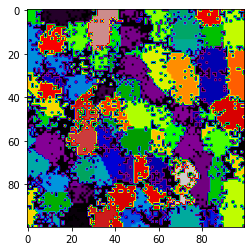

In [12]:
sim.plot_true()

# Compute the covariance structure of the scRNAseq reference


In [13]:
sim.compute_covariance(sc_ref, celltypes)

# Compute celltype proportions

In [14]:
sim.celltype_props = sim.celltype_props + np.ones_like(sim.celltype_props) * unif_const
sim.celltype_props /= np.sum(sim.celltype_props)

# Assign celltypes
Celltypes stored in self.classified+celltypes

In [15]:
sim.classify_celltypes(ct_list=celltypes)

# Generate nuclei in cells
Map of nuclei stored in self.nuclei

In [16]:
sim.generate_nuclei_centers(n_pix_per_nuc=pix_per_nuc)

# Generate sample digital gene expression matrix
DGE stored in self.merfish_dge

In [17]:
sim.generate_merfish_dge(dge_scaling_factor = dge_scaling_factor)

# Place mRNA spots in the cells

In [18]:
sim.place_transcripts(dist_from_nuc_scale=dist_from_nuc_scale)

# Place a random transcript at each corner.
This is not neccesary, however later on if you would like to evaluate accuracy of the segmentation map against the true map this is very useful to keep the two aligned.

In [19]:
sim.place_transcripts_at_corners()

# Save example

In [20]:
with open('../simulated_example/spots.npy','wb') as f:
    np.save(f,sim.spots,allow_pickle=True)
with open('../simulated_example/nuclei.npy','wb') as f:
    np.save(f,sim.nuc_df,allow_pickle=True)
with open('../simulated_example/true_map.npy','wb') as f:
    np.save(f,sim.true_map,allow_pickle=True)
with open('../simulated_example/celltypes.npy','wb') as f:
    np.save(f,sim.classified_celltypes,allow_pickle=True)